## Analyze A/B Test Results

You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).  **Please save regularly

This project will assure you have mastered the subjects covered in the statistics lessons.  The hope is to have this project be as comprehensive of these topics as possible.  Good luck!

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [5]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [6]:
df[(df.landing_page == 'new_page') & (df.group != 'treatment')].count() + df[(df.landing_page != 'new_page') & (df.group == 'treatment')].count()

user_id         3893
timestamp       3893
group           3893
landing_page    3893
converted       3893
dtype: int64

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# We should only use the rows that we can feel confident in the accuracy of the data

df2 = df.query('(landing_page == "new_page" & group == "treatment") or (landing_page == "old_page" & group == "control")')
df2.shape

(290585, 5)

In [9]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [10]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

c. What is the row information for the repeat **user_id**? 

In [11]:
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [12]:
df2 = df2.drop([1899]) # this is the index which we can see in above cell
df2[df2.duplicated(['user_id'], keep=False)]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [13]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [14]:
df2.groupby(['group'])['converted'].mean()

group
control      0.120386
treatment    0.118808
Name: converted, dtype: float64

d. What is the probability that an individual received the new page?

In [15]:
df2.query('landing_page == "new_page"').count()[0] / len(df2.index)

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

**If we only consider the probability of being converted, we have insignificant difference between 12% and 11.9% to make conclusions about one page leading to more conversions than the other one.**

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_0: p_{old} - p_{new} \geq 0$$

$$H_1: p_{old} - p_{new} < 0$$ 

... which is the same as: 

$$H_0: p_{new} - p_{old} \leq 0$$

$$H_1: p_{new} - p_{old} > 0$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [16]:
# We are looking at a null where there is no difference in conversion based on the page, which means the conversions for each page are the same

df2.converted.mean()

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [17]:
df2.query('converted == 1').count()[0] / len(df2.index) # just another way to calculate the same as above

0.11959708724499628

c. What is $n_{new}$?

d. What is $n_{old}$?

In [18]:
df2.groupby(['landing_page']).count()

,user_id,timestamp,group,converted
landing_page,,,,
new_page,145310,145310,145310,145310
old_page,145274,145274,145274,145274


e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [19]:
size = 145310 # new_page count from the above table

# simulate 0 or 1, n_new times, with a probability of p_new for 1
new_page_converted = np.random.choice(2, size, p=(1-0.1195, 0.1195))
new_page_converted

array([0, 0, 1, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [20]:
size = 145274 # old_page count from the above table

# simulate 0 or 1, n_old times, with a probability of p_old for 1
old_page_converted = np.random.choice(2, size, p=(1-0.1195, 0.1195))
old_page_converted

array([0, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [21]:
new_page_converted.mean() - old_page_converted.mean()

-0.0012203117407142416

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [22]:
# Perform the sampling distribution for the difference in converted between the two pages over 10,000 iterations of calculating an estimate from the null

p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.choice(2, size, p=(1-0.1195, 0.1195))
    old_page_converted = np.random.choice(2, size, p=(1-0.1195, 0.1195))
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

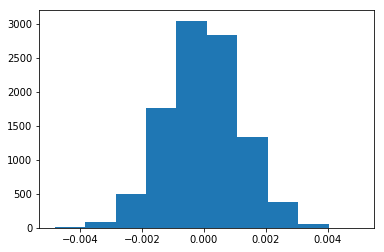

In [23]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

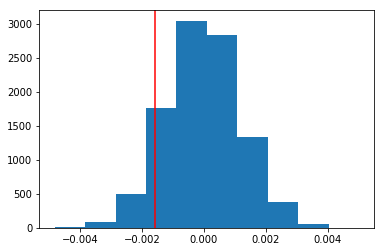

In [24]:
obs_diff = 0.118808 - 0.120386
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');

In [25]:
p_diffs = np.array(p_diffs) # convert list to np array

# Compute p-value
(p_diffs > obs_diff).mean()

0.90649999999999997

In [26]:
(p_diffs > obs_diff).mean() <= 0.05 # reject the null?

False

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Here we computed a "p-value". When a p-value is less than or equal to the significance level, you reject the null hypothesis. In this case, with a type I error rate of 0.05, we do NOT have evidence that new page leads to more conversions.**

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [27]:
import statsmodels.api as sm

convert_old = df2.query('landing_page == "old_page" & converted == 1').count()[0]
convert_new = df2.query('landing_page == "new_page" & converted == 1').count()[0]
n_old = df2.query('landing_page == "old_page"').count()[0]
n_new = df2.query('landing_page == "new_page"').count()[0]

convert_old, convert_new, n_old, n_new

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(17489, 17264, 145274, 145310)

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [28]:
# In the two sample test, alternative='smaller' means that the alternative hypothesis is p1 (old) < p2 (new)

z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3109241984234394, 0.90505831275902449)

In [29]:
from scipy.stats import norm

z_score > norm.ppf(1-(0.05/2)) # reject the null?

False

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**When a p-value is less than or equal to the significance level, you reject the null hypothesis. Since the z-score does not exceed the critical value at 95% confidence, we fail to reject the null hypothesis. The findings are the same as in parts j. and k.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since each row is either a conversion or no conversion, we need to use a Logistic Regression for categorical variables.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [30]:
df2['intercept'] = 1

df2[['ab_page_control', 'ab_page']] = pd.get_dummies(df['group'])
df2 = df2.drop('ab_page_control', axis = 1) # to create matrices that are full rank, we need to always drop one of the columns when fitting our dummy variables
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [31]:
# x = one or more explanatory variables (or independent variables)
# y = (predict) scalar response (or dependent variable)

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']]) # (y, list of x)
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [32]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Wed, 21 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        11:55:45   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.190. A low p-value (< 0.05) indicates that you can reject the null hypothesis. In our case, treatment is not statistically significant to predict the conversion, so we fail to reject the null.** 

**The main null hypothesis of a multiple logistic regression is that there is no relationship between the x variables ("ab_page") and the y variable ("converted").**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**There are many factors to consider when designing an A/B test and drawing conclusions based on its results. It is a good idea to consider a novelty effect, traffic amount, run time for the experiment, imbalance in the population and other factors than can influence the results or the fairness of the experiment.**

**The disadvantage to adding additional terms into your regression model is that an overfit model can cause the regression coefficients, p-values, and R-squared to be misleading.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [33]:
countries = pd.read_csv("countries.csv")
countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [34]:
df2 = df2.merge(countries, how='left' ,on='user_id')
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [35]:
df2.isnull().sum() # checking for null values in the merged dataset

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
intercept       0
ab_page         0
country         0
dtype: int64

In [36]:
df2.country.unique() # which countries do we have?

array(['US', 'CA', 'UK'], dtype=object)

In [37]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country'])
df2 = df2.drop('US', axis = 1) # this one will be used as a baseline
df2.groupby(['country']).mean() # check if dummy variables were correctly assigned

,user_id,converted,intercept,ab_page,CA,UK
country,,,,,,
CA,788640.270639,0.115318,1.0,0.503552,1.0,0.0
UK,787678.848246,0.120594,1.0,0.498247,0.0,1.0
US,788075.662148,0.119547,1.0,0.500459,0.0,0.0


In [38]:
logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'UK']]) # (y, list of x)
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Wed, 21 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        11:55:46   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Our p-values over the 0.05 show that country is not statistically significant to predict the conversion.**

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [39]:
df2.head(1)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0


In [40]:
df2[['CA', 'UK', 'US']] = pd.get_dummies(df2['country']) # to add US once again

df2[['CA_new', 'UK_new', 'US_new']] = df2[['CA', 'UK', 'US']].multiply(df2["ab_page"], axis="index")
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK,US,CA_new,UK_new,US_new
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0,1,0,0,0


In [41]:
df2 = df2.drop('US', axis = 1) # this one will be used as a baseline
df2 = df2.drop('US_new', axis = 1) # this one will be used as a baseline

logit_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'CA', 'CA_new', 'UK', 'UK_new']]) # (y, list of x)
results = logit_mod.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Wed, 21 Nov 2018   Pseudo R-squ.:               3.482e-05
Time:                        11:55:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
CA_new        -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
UK_new         0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

### Conclusions:

**Again, our p-values over the 0.05 show that interaction between page and country is not statistically significant to predict the conversion.**

**All our tests confirmed that we fail to reject the null hypothesis. There is no evidence that new page leads to more conversions.**

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [42]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0